Step 0:
Set x-axis limits: 2024-09-08 05:00:00 to 2024-09-09 02:23:00


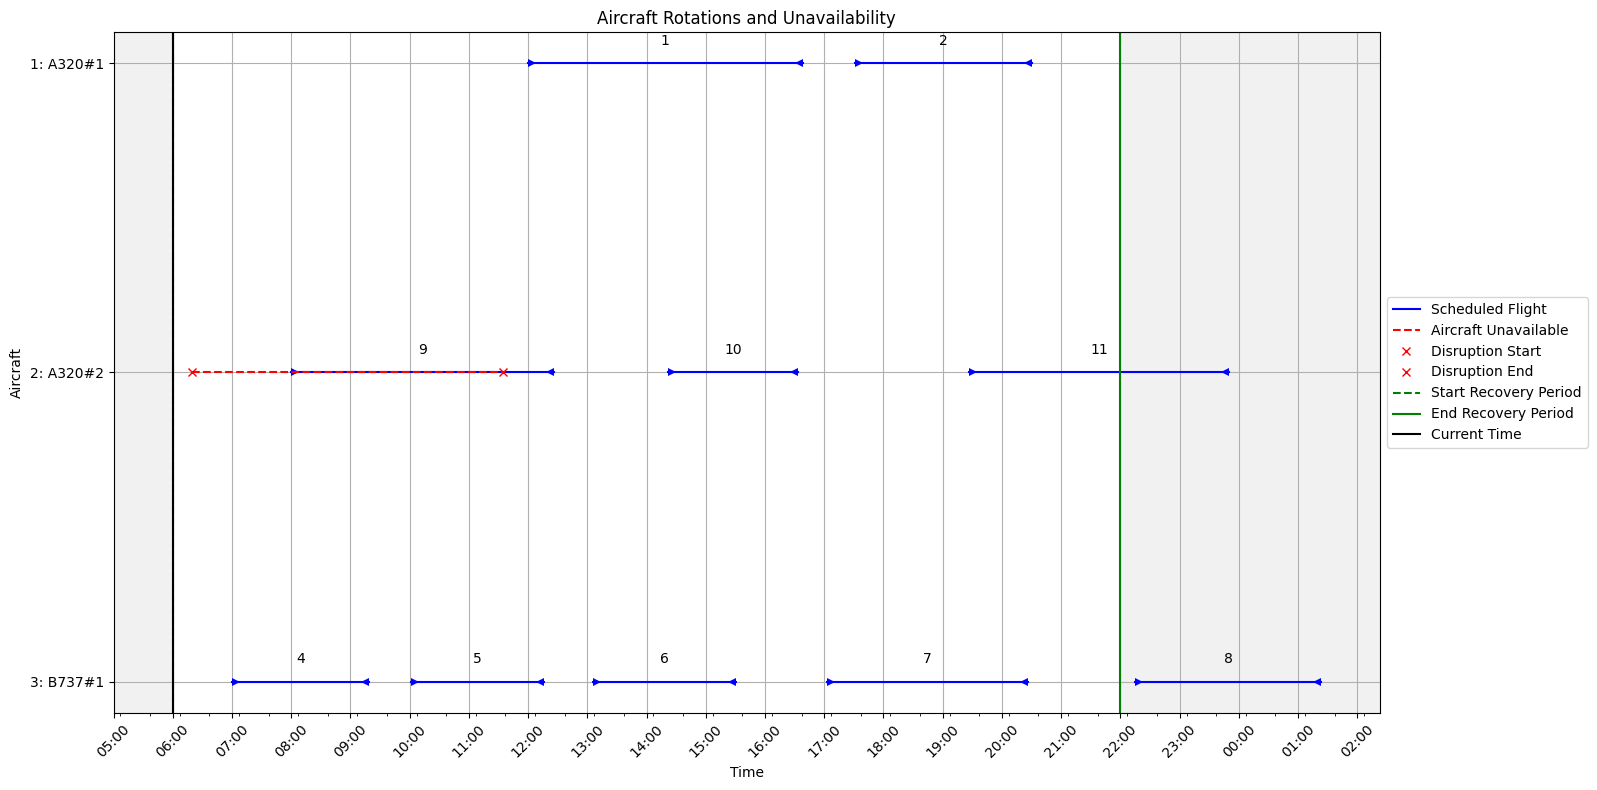

Actual x-axis limits after plotting: (19974.208333333332, 19975.099305555555)
[[2 9 0 960 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan]
 [1 nan nan 1 360 638 2 691 870 nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan]
 [2 19 335 9 120 386 10 502 633 11 807 1070 nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan]
 [3 nan nan 4 60 199 5 241 376 6 426 571 7 663 866 8 975 1163 nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]]

Action taken: 3, Reward: 0
Final state:
Flight 7: Departure: 2024-09-08 19:57:00, Arrival: 2024-09-08 23:20:00
  Status: Delayed
  Line start: 2024-09-08 19:57:00, Line end: 2024-09-08 23:20:00
  Departure marker: 2024-09-08 20:01:00, Arrival marker: 2024-09-08 23:16:00
Flight 8: Departure: 2024-09-

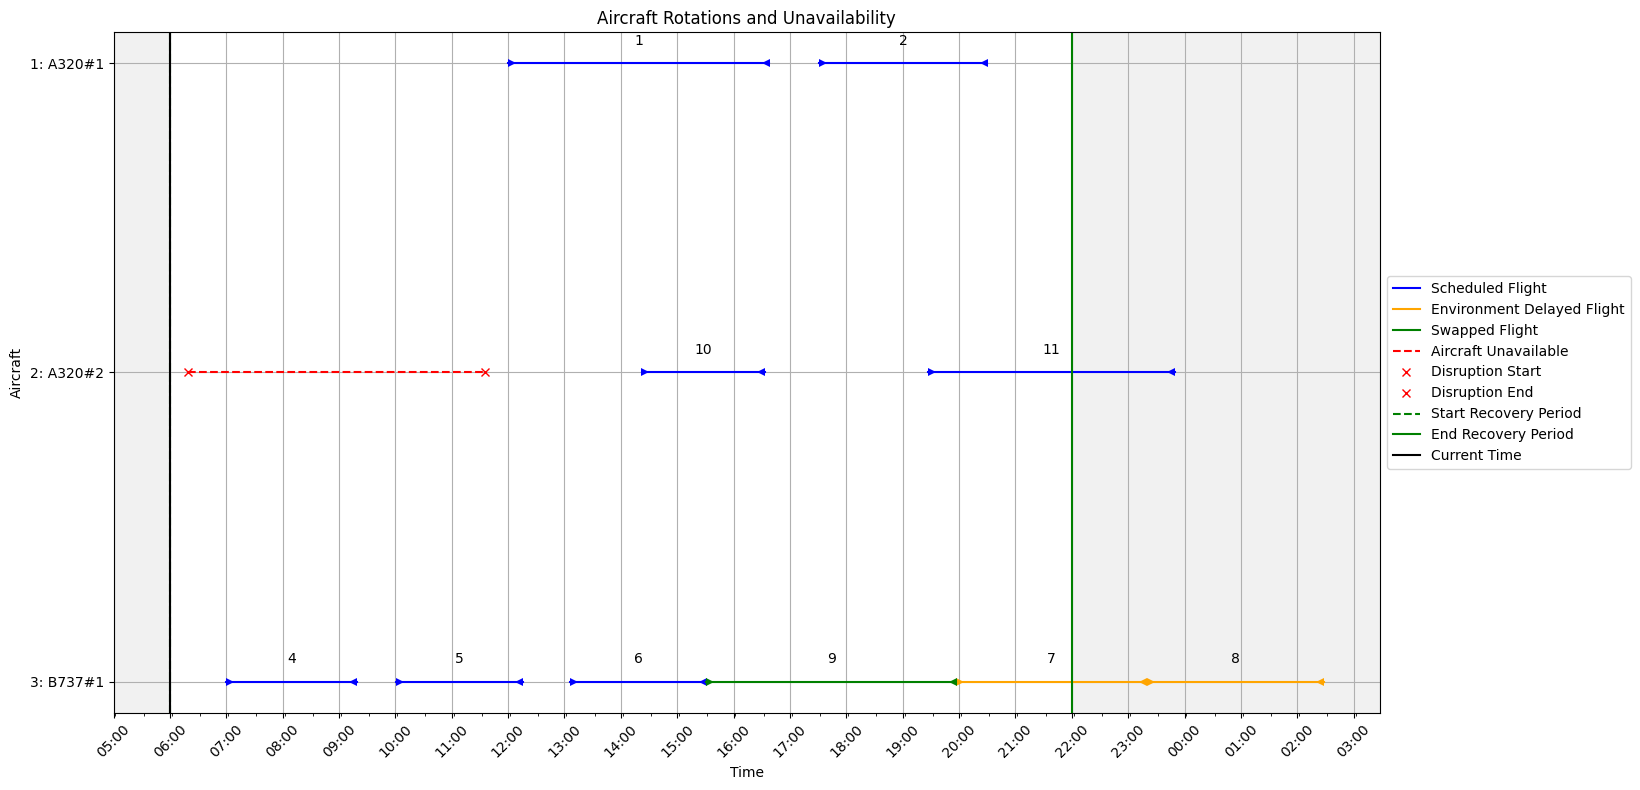

Actual x-axis limits after plotting: (19974.208333333332, 19975.144444444446)
[[nan nan 60 900 nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan]
 [1 nan nan 1 360 638 2 691 870 nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan]
 [2 19 335 10 502 633 11 807 1070 nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan]
 [3 nan nan 4 60 199 5 241 376 6 426 571 9 571 837 7 837 1040 8 1040 1228
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]]
Total Reward: 0
Total Steps: 1


(0, 1)

In [1]:
import os
import torch as th
import numpy as np
import gymnasium as gym
from stable_baselines3 import DQN
import matplotlib.pyplot as plt
from scripts.utils import *
from scripts.visualizations import *
from src.config import *
from datetime import datetime, timedelta
from src.environment import AircraftDisruptionEnv
from scripts.visualizations import StatePlotter

# Load the model and run inference
def run_inference(model_path, scenario_folder):
    # Load the scenario data
    data_dict = load_scenario_data(scenario_folder)

    # Extract necessary data for the environment
    aircraft_dict = data_dict['aircraft']
    flights_dict = data_dict['flights']
    rotations_dict = data_dict['rotations']
    alt_aircraft_dict = data_dict['alt_aircraft']
    config_dict = data_dict['config']

    # Initialize the environment
    env = AircraftDisruptionEnv(
        aircraft_dict, 
        flights_dict, 
        rotations_dict, 
        alt_aircraft_dict, 
        config_dict
    )

    # Load the trained model and set the environment
    model = DQN.load(model_path)
    model.set_env(env)

    # Create StatePlotter object for visualizing the environment state
    state_plotter = StatePlotter(
        aircraft_dict=aircraft_dict, 
        flights_dict=flights_dict, 
        rotations_dict=rotations_dict, 
        alt_aircraft_dict=alt_aircraft_dict,
        start_datetime=env.start_datetime,
        end_datetime=env.end_datetime
    )

    # Reset the environment for inference
    obs, _ = env.reset()
    done_flag = False
    total_reward = 0
    step_num = 0
    max_steps = 1000  # Set a maximum number of steps to prevent infinite loops

    while not done_flag and step_num < max_steps:
        # Visualize the current state
        print(f"Step {step_num}:")

        # Extract necessary information from the environment for plotting
        swapped_flights = env.swapped_flights
        environment_delayed_flights = env.environment_delayed_flights
        current_datetime = env.current_datetime
        updated_flights_dict = env.flights_dict
        cancelled_flights = env.penalized_cancelled_flights

        # Plot the current state
        state_plotter.plot_state(
            updated_flights_dict, 
            swapped_flights, 
            environment_delayed_flights, 
            cancelled_flights, 
            current_datetime
        )

        # Use the trained model to predict the action
        action, _ = model.predict(obs, deterministic=True)

        # Take action in the environment
        obs, reward, terminated, truncated, info = env.step(action)

        # Accumulate the reward
        total_reward += reward

        print(f"Action taken: {action}, Reward: {reward}")

        # Combine terminated and truncated flags
        done_flag = terminated or truncated

        step_num += 1


    print("================================================")
    print("Final state:")
    # Plot final state
    state_plotter.plot_state(
        updated_flights_dict, 
        swapped_flights, 
        environment_delayed_flights, 
        cancelled_flights, 
        current_datetime
    )
    print_state_nicely(env.state)


    print(f"Total Reward: {total_reward}")
    print(f"Total Steps: {step_num}")

    return total_reward, step_num

# Specify the model path and the scenario folder you want to inference
MODEL_PATH = "../trained_models/dqn_10000000d_1000u-1.zip"

SCENARIO_FOLDER = "../data/Training-1k-small-full/Scenario_02" # Training set
# SCENARIO_FOLDER = "../data/Example/PoC-scenario" # Example set
# SCENARIO_FOLDER = "../data/Example/Example-scenario-3"

# Verify folder and model exist
if not os.path.exists(SCENARIO_FOLDER):
    raise FileNotFoundError(f"Scenario folder not found: {SCENARIO_FOLDER}")

if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Model file not found: {MODEL_PATH}")

# Run inference
run_inference(MODEL_PATH, SCENARIO_FOLDER)

